# Preprocessing

### Examine the Dataset

In [1]:
import librosa.display
import librosa.util
import matplotlib.pyplot as plt
from IPython.display import Audio
import os
import scipy
import numpy as np

In [2]:
clean_audio_dir = "../data/raw/edinburgh-noisy-speech-db/clean_trainset_28spk_wav/"
audio_file = "p236_002.wav"
clean_audio_f = clean_audio_dir + audio_file
Audio(clean_audio_f)

In [3]:
noisy_audio_dir = "../data/raw/edinburgh-noisy-speech-db/noisy_trainset_28spk_wav/"
noisy_audio_f = noisy_audio_dir + audio_file

Audio(noisy_audio_f)

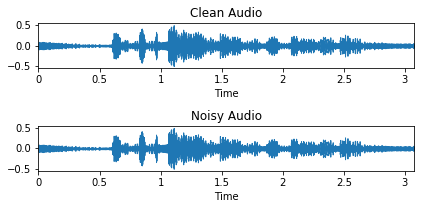

In [4]:
# Plot the waveforms, sr = 22050
y, sr = librosa.load(clean_audio_f)
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.title('Clean Audio')

y_noise, sr = librosa.load(clean_audio_f)
plt.subplot(3, 1, 2)
librosa.display.waveplot(y, sr=sr)
plt.title('Noisy Audio')

plt.tight_layout()

### Short-Time Fourier Transform

First, convert samples into STFT

In [5]:
window_length = 256;
win = scipy.signal.hamming(window_length,"periodic");
hop_length = round(0.25 * window_length);
fft_length = window_length;

In [6]:
# downsampling to 8k
input_fs = sr;
fs = 8e3;

y = librosa.resample(y, target_sr = fs, orig_sr = sr)
sr = fs

In [7]:
n = len(y)
y_pad = librosa.util.fix_length(y, n + fft_length // 2)
D = librosa.stft(y_pad.astype(np.float32),
    n_fft = fft_length,
    win_length = window_length,
    window = win,
    hop_length = hop_length)
magnitude, phase = librosa.magphase(D)

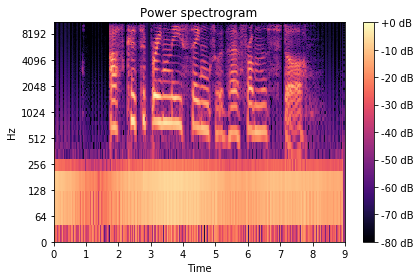

In [8]:
librosa.display.specshow(librosa.amplitude_to_db(magnitude, ref=np.max), y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

At this point, we will use the generate new magnitudes using our NN

In [9]:
D.shape

(129, 387)

Then, invert STFT back to audio format

In [10]:
D_rec = magnitude * phase 

In [11]:
audio_rec = librosa.istft(D_rec,
    length=n,
    win_length = window_length,
    window = win,
    hop_length = hop_length)

In [12]:
Audio(audio_rec, rate = sr)

### Building Targets and Predictors

In [13]:
num_features  = fft_length/2 + 1;
num_segments  = 8;

# Create array of targets and predictors

### Full Script

TODO: Full Script which will take process all the audio files in raw format and store them in processed format, using the above constraints

Script should store data in a format that can be easily saved are retrieved for later use

In [16]:
import os
import librosa
import scipy
import numpy as np
import progressbar

def get_stft(y, sr):
    # define vars
    window_length = 256;
    win = scipy.signal.hamming(window_length,"periodic");
    overlap = round(0.75 * window_length);
    fft_length = window_length;
    # downsampling
    target_sr = 8e3;
    y = librosa.resample(y, target_sr = target_sr, orig_sr = sr)
    sr = target_sr
    # padding, because input must be multiple of fft window
    n = len(y)
    y_pad = librosa.util.fix_length(y, n + fft_length // 2)
    # get STFT
    D = librosa.stft(y_pad.astype(np.float32),
        n_fft = fft_length,
        win_length = window_length,
        window = win,
        hop_length = overlap)
    return D

def process_audio(process_all = False):
    raw_dir = "../data/raw/edinburgh-noisy-speech-db/"
    processed_dir = "../data/processed/edinburgh-noisy-speech-db/"
    clean_audio_dir = "clean_trainset_28spk_wav/"
    noisy_audio_dir = "noisy_trainset_28spk_wav/"
    log_trainset = "log_trainset_28spk.txt"
    audio_files = []
    
    # list files
    f = open(raw_dir + log_trainset, "r")
    for x in f:
        audio_files.append(x.split()[0] + ".wav")
    f.close()
    
    if process_all == False:
        audio_files = audio_files[0:128]
        
    print("Processing " + str(len(audio_files)) + " files")
    
    with progressbar.ProgressBar(max_value=len(audio_files)) as bar:
        for i, f in enumerate(audio_files):
            for a in [clean_audio_dir, noisy_audio_dir]:
                y, sr = librosa.load(raw_dir + a + f)
                D = get_stft(y, sr)
                # save file
                out_dir = processed_dir + a
                if not os.path.exists(out_dir):
                    os.makedirs(out_dir)
                np.save(out_dir + f.replace(".wav", ".npy"), D)
            bar.update(i)
            
process_audio()

Processing 128 files


100% (128 of 128) |######################| Elapsed Time: 0:00:39 Time:  0:00:39
